In [1]:
#pip install yfinance ta pyfolio empyrical

In [ ]:
#https://www.allquant.co/post/magic-of-log-returns-practical-part-2

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dt
import os
import warnings
import ta
import empyrical as em

# Ignore printing all warnings
warnings.filterwarnings('ignore')

In [3]:
# downloading historical necessary data for backtesting and analysis
_start = dt.date(2011,1,1)
_end = dt.date.today()
ticker = 'TORNTPOWER.NS'
df = yf.download(ticker, start = _start, end = _end)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.dropna(inplace = True)

In [5]:
# calculating buy and hold strategy returns
df['bnh_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,bnh_returns
Date,,,,,,,
2011-01-03,276.000000,281.000000,275.149994,276.200012,213.846756,40361,NaN
2011-01-04,277.000000,280.399994,273.500000,274.450012,212.491791,59006,-0.006356
2011-01-05,275.100006,277.500000,270.149994,271.950012,210.556168,58289,-0.009151


In [6]:
# creating SMA and EMA short and long indicators
short = 10 # Short Period
long = 50 # Long Period
df['SMA_Short'] = ta.trend.SMAIndicator(df['Close'],window=short).sma_indicator()
df['SMA_Long'] = ta.trend.SMAIndicator(df['Close'],window=long).sma_indicator()
df['EMA_Short'] = ta.trend.EMAIndicator(df['Close'],window=short).ema_indicator()
df['EMA_Long'] = ta.trend.EMAIndicator(df['Close'],window=long).ema_indicator()
df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df.tail(5)

,Close,Adj Close,Volume,bnh_returns,SMA_Short,SMA_Long,EMA_Short,EMA_Long
Date,,,,,,,,
2024-01-19,988.950012,988.950012,274883,-0.008207,1009.949994,919.820999,998.526165,920.858842
2024-01-22,988.950012,988.950012,0,0.000000,1007.369995,924.546998,996.785046,923.529084
2024-01-23,984.099976,984.099976,359714,-0.004916,1003.674994,929.026998,994.478670,925.904413
2024-01-24,1000.049988,1000.049988,428519,0.016078,1001.494995,933.474998,995.491636,928.812083
2024-01-25,1000.799988,1000.799988,194979,0.000750,999.544995,937.082997,996.456791,931.635138


<Axes: xlabel='Date'>

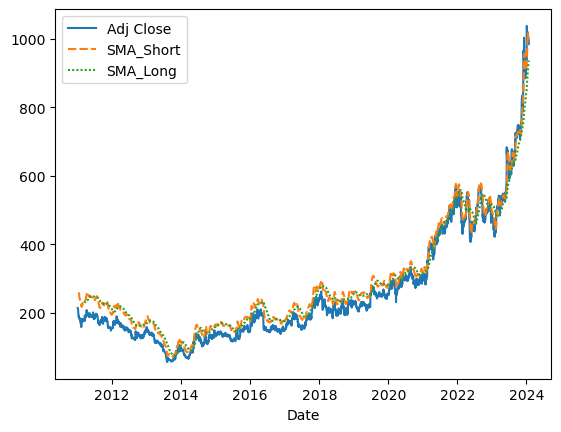

In [7]:
import seaborn as sns
sns.lineplot(df[['Adj Close','SMA_Short','SMA_Long']])

<Axes: xlabel='Date'>

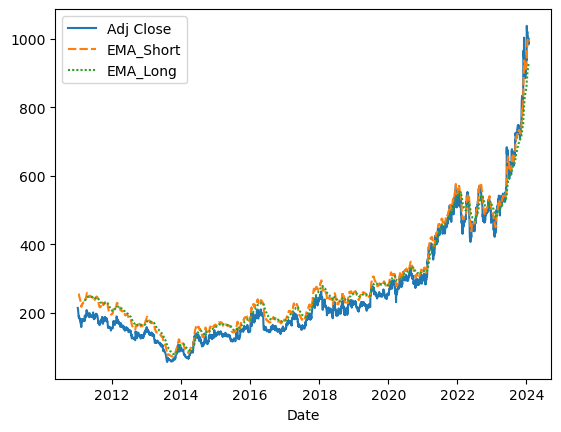

In [8]:
sns.lineplot(df[['Adj Close','EMA_Short','EMA_Long']])

In [9]:
# SMA Cross over Strategy (Intraday margin trading strategies) vs. Daily position strategies

# Position Strategy
# BUY condition
df['sma_signal'] = np.where((df['SMA_Short'] > df['SMA_Long']),1,np.nan)
# SELL condition
df['sma_signal'] = np.where( (df['SMA_Short'] < df['SMA_Long']),0,df['sma_signal'])

# Margin Trading Strategy
#df['sma_signal'] = np.where((df['SMA_Short'] > df['SMA_Long']),1,-1)

# creating long and short positions
df['sma_position'] = df['sma_signal'].replace(to_replace=np.nan, method='ffill')

# shifting by 1, to account of close price return calculations
df['sma_position'] = df['sma_position'].shift(1)

# calculating stretegy returns
df['sma_strategy_returns'] = df['bnh_returns'] * (df['sma_position'])

df.tail(10)


,Close,Adj Close,Volume,bnh_returns,SMA_Short,SMA_Long,EMA_Short,EMA_Long,sma_signal,sma_position,sma_strategy_returns
Date,,,,,,,,,,,
2024-01-12,1013.549988,1013.549988,117332,-0.006638,996.874988,893.582000,997.120568,903.080070,1.0,1.0,-0.006638
2024-01-15,1011.349976,1011.349976,389747,-0.002173,1003.764984,899.432000,999.707733,907.325949,1.0,1.0,-0.002173
2024-01-16,1008.700012,1008.700012,335717,-0.002624,1010.864984,905.017999,1001.342693,911.301402,1.0,1.0,-0.002624
2024-01-17,1001.900024,1001.900024,312608,-0.006764,1016.624988,910.146000,1001.444026,914.854290,1.0,1.0,-0.006764
2024-01-18,997.099976,997.099976,175007,-0.004802,1014.874988,915.114999,1000.654198,918.079611,1.0,1.0,-0.004802
2024-01-19,988.950012,988.950012,274883,-0.008207,1009.949994,919.820999,998.526165,920.858842,1.0,1.0,-0.008207
2024-01-22,988.950012,988.950012,0,0.000000,1007.369995,924.546998,996.785046,923.529084,1.0,1.0,0.000000
2024-01-23,984.099976,984.099976,359714,-0.004916,1003.674994,929.026998,994.478670,925.904413,1.0,1.0,-0.004916
2024-01-24,1000.049988,1000.049988,428519,0.016078,1001.494995,933.474998,995.491636,928.812083,1.0,1.0,0.016078


In [10]:
# EMA Cross over Strategy

# BUY condition
df['ema_signal'] = np.where( (df['EMA_Short'] > df['EMA_Long']),1,np.nan)

# SELL condition
df['ema_signal'] = np.where( (df['EMA_Short'] < df['EMA_Long']),0,df['ema_signal'])
# creating long and short positions
df['ema_position'] = df['ema_signal'].replace(to_replace=np.nan, method='ffill')

# shifting by 1, to account of close price return calculations
df['ema_position'] = df['ema_position'].shift(1)

# calculating stretegy returns
df['ema_strategy_returns'] = df['bnh_returns'] * (df['ema_position'])

df.sample(10)

,Close,Adj Close,Volume,bnh_returns,SMA_Short,SMA_Long,EMA_Short,EMA_Long,sma_signal,sma_position,sma_strategy_returns,ema_signal,ema_position,ema_strategy_returns
Date,,,,,,,,,,,,,,
2019-11-21,286.100006,255.308685,666527,-0.006098,292.564999,283.954000,289.569639,285.537223,1.0,1.0,-0.006098,1.0,1.0,-0.006098
2018-07-24,231.449997,202.366974,678911,0.026044,225.020001,235.775000,225.768051,233.671993,0.0,0.0,0.000000,0.0,0.0,0.000000
2021-05-28,429.250000,403.705872,804669,-0.001513,434.020001,416.145001,431.289955,411.732424,1.0,1.0,-0.001513,1.0,1.0,-0.001513
2015-01-13,168.850006,139.032761,1399345,0.005344,162.789998,160.519000,164.433974,159.730017,1.0,1.0,0.005344,1.0,1.0,0.005344
2013-02-05,171.100006,138.217087,41711,-0.005537,171.790002,176.680001,172.567527,175.145343,0.0,0.0,-0.000000,0.0,0.0,-0.000000
2020-10-20,302.350006,279.665894,372741,-0.006100,301.020001,326.343000,302.777073,317.759746,0.0,0.0,-0.000000,0.0,0.0,-0.000000
2011-08-03,234.600006,183.469513,51345,-0.008489,242.120001,243.114000,241.036019,243.412054,0.0,1.0,-0.008489,0.0,0.0,-0.000000
2012-06-26,177.750000,143.589081,27709,0.002817,184.559999,193.180000,183.348211,193.147974,0.0,0.0,0.000000,0.0,0.0,0.000000
2011-06-09,241.649994,187.096527,14499,-0.013360,244.434999,249.177000,244.015060,245.741458,0.0,0.0,-0.000000,0.0,0.0,-0.000000


In [11]:
df['ema_strategy_returns'].describe()

count    3173.000000
mean        0.000353
std         0.018059
min        -0.160143
25%        -0.002779
50%         0.000000
75%         0.001630
max         0.173805
Name: ema_strategy_returns, dtype: float64

In [12]:
df['bnh_returns'].describe()

count    3222.000000
mean        0.000479
std         0.023424
min        -0.160143
25%        -0.012164
50%        -0.000607
75%         0.010480
max         0.182200
Name: bnh_returns, dtype: float64

In [13]:
df['sma_strategy_returns'].describe()

count    3173.000000
mean        0.000292
std         0.017730
min        -0.160143
25%        -0.002890
50%         0.000000
75%         0.001159
max         0.173805
Name: sma_strategy_returns, dtype: float64

Buy and hold returns: 1.5432952819956736
SMA_Strategy returns: 0.9259069689570063
EMA_Strategy returns: 1.119934964099274


<Axes: xlabel='Date'>

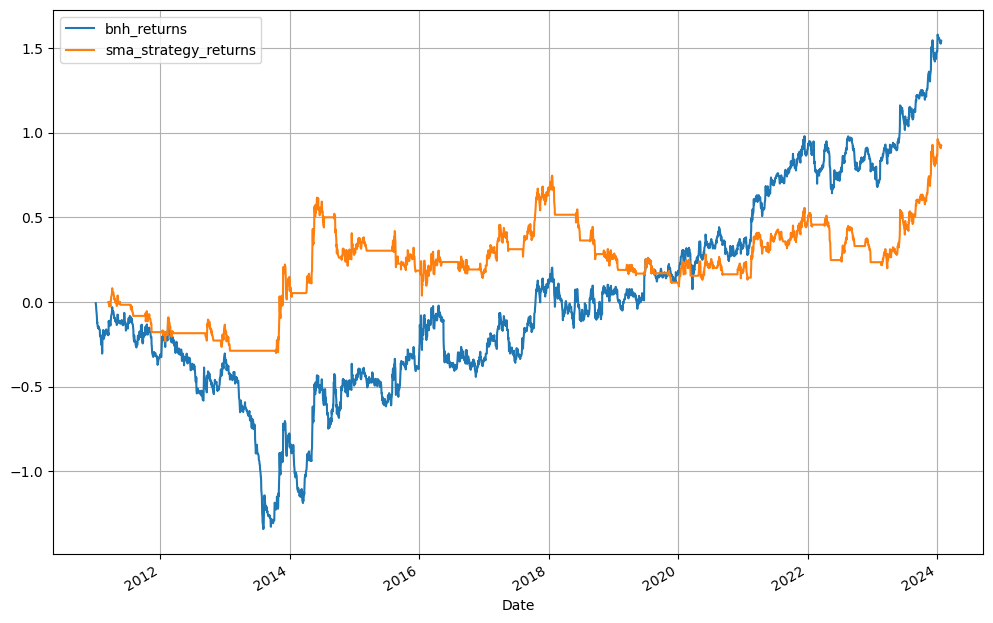

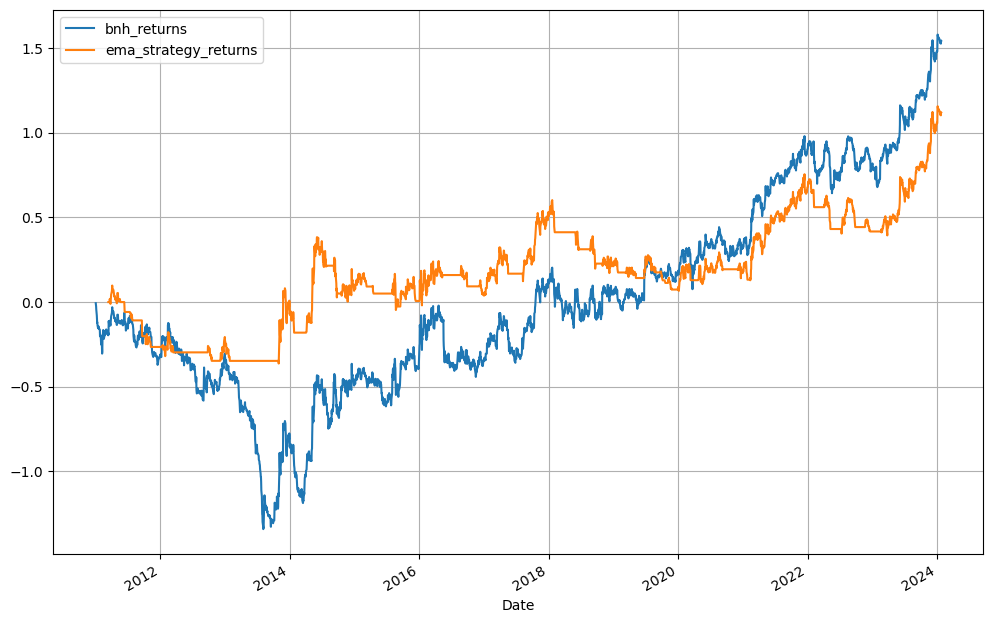

In [14]:
# comparing buy & hold strategy / MA crosover strategy
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("SMA_Strategy returns:",df['sma_strategy_returns'].cumsum()[-1])
print("EMA_Strategy returns:",df['ema_strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','sma_strategy_returns']].cumsum().plot(grid=True, figsize=(12, 8))

# plotting strategy historical performance over time
df[['bnh_returns','ema_strategy_returns']].cumsum().plot(grid=True, figsize=(12, 8))

In [15]:
# 5. Compute performance metrics
annual_rf = 0.068569
daily_rf = annual_rf / 252

# Annual returns - ((1+r1)(1+r2)....)^(252/length of the data) -1
annual_return = (df['bnh_returns'] + 1).prod() ** (252 / len(df)) - 1
annual_return1 = df['bnh_returns'].mean()*252

# Annual volatility - standard deviation of returns * sqrt 252
annual_volatility = df['bnh_returns'].std() * np.sqrt(252)

# Sharpe Ratio
sharpe_ratio = (annual_return - annual_rf) / annual_volatility

# Maximum Drawdown
#cum_return - 
cum_return = (1 + df['bnh_returns']).cumprod()
cum_max = cum_return.cummax()
drawdown = (cum_max - cum_return) / cum_max
max_drawdown = drawdown.max()

# Calmar Ratio
calmar_ratio = annual_return / max_drawdown

# Daily Value at Risk (VaR)
daily_var = -df['bnh_returns'].quantile(0.05)

# Sortino Ratio
target_return = daily_rf
neg_std = df[df['bnh_returns'] < target_return]['bnh_returns'].std()
sortino_ratio = (annual_return - annual_rf) / (neg_std * np.sqrt(252))


In [16]:
print(f"Buy & Hold Strategy")
print(f"Geometric Annual Return: {annual_return:.2%}")
print(f"Annual Volatility: {annual_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Daily VaR: {daily_var:.2%}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Annual Return1: {annual_return1:.2f}")

Buy & Hold Strategy
Geometric Annual Return: 5.37%
Annual Volatility: 37.18%
Sharpe Ratio: -0.04
Max Drawdown: 76.87%
Calmar Ratio: 0.07
Daily VaR: 3.18%
Sortino Ratio: -0.07
Annual Return1: 0.12


In [17]:
# 5. Compute performance metrics
annual_rf = 0.068569
daily_rf = annual_rf / 252

# Annual returns - ((1+r1)(1+r2)....)^(252/length of the data) -1
annual_returnsma = (df['sma_strategy_returns'] + 1).prod() ** (252 / len(df)) - 1
annual_returnsma1 = df['sma_strategy_returns'].mean()*252

# Annual volatility - standard deviation of returns * sqrt 252
annual_volatilitysma = df['sma_strategy_returns'].std() * np.sqrt(252)

# Sharpe Ratio
sharpe_ratiosma = (annual_returnsma - annual_rf) / annual_volatilitysma

# Maximum Drawdown
#cum_return - 
cum_returnsma = (1 + df['sma_strategy_returns']).cumprod()
cum_maxsma = cum_returnsma.cummax()
drawdownsma = (cum_maxsma - cum_returnsma) / cum_maxsma
max_drawdownsma = drawdownsma.max()

# Calmar Ratio
calmar_ratiosma = annual_returnsma / max_drawdownsma

# Daily Value at Risk (VaR)
daily_varsma = -df['sma_strategy_returns'].quantile(0.05)

# Sortino Ratio
target_return = daily_rf
neg_stdsma = df[df['sma_strategy_returns'] < target_return]['sma_strategy_returns'].std()
sortino_ratiosma = (annual_return - annual_rf) / (neg_stdsma * np.sqrt(252))


In [18]:
print(f"SMA Strategy")
print(f"SMA Annual Return: {annual_returnsma:.2%}")
print(f"SMA Annual Volatility: {annual_volatilitysma:.2%}")
print(f"SMA Sharpe Ratio: {sharpe_ratiosma:.2f}")
print(f"SMA Max Drawdown: {max_drawdownsma:.2%}")
print(f"SMA Calmar Ratio: {calmar_ratiosma:.2f}")
print(f"SMA Daily VaR: {daily_varsma:.2%}")
print(f"SMA Sortino Ratio: {sortino_ratiosma:.2f}")
print(f"SMA Annual Return1: {annual_returnsma1:.2f}")

SMA Strategy
SMA Annual Return: 3.44%
SMA Annual Volatility: 28.15%
SMA Sharpe Ratio: -0.12
SMA Max Drawdown: 52.75%
SMA Calmar Ratio: 0.07
SMA Daily VaR: 2.50%
SMA Sortino Ratio: -0.08
SMA Annual Return1: 0.07
